In [1]:
from datetime import datetime
from time import sleep

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

import psutil

In [2]:
def get_cpu_stats():
    """
    Returns a dict with cpu frequency and temperature.
    This is not written for a generic computer.
    
    return dict
    """
    
    freq = psutil.cpu_freq(percpu=True)
    cpu_freq = {}
    avgs = {}
    
    for i, f in enumerate(freq):
        cpu_freq[i] = f.current
        
    s = pd.Series(cpu_freq)
    
    avgs['avg_freq'] = s.mean()
    avgs['max_freq'] = s.max()
    avgs['min_freq'] = s.min()
    avgs['avg_temp'] = psutil.sensors_temperatures()['k10temp'][0].current

    return cpu_freq, avgs

In [3]:
class StatsMonitor:
    """
    StatsMonitor gathers clock and temperature data from the computer,
    and plots them.
    """
    
    def __init__(self):
        self.data = []
        self.colors = {
            'avg_freq': 'blue', 'max_freq': 'green', 'min_freq': 'red',
            'avg_temp': 'purple'
        }
        
    def get_data(self, n_points, interval=10):
        """
        Get clock and temperature data from the processor, 
        n_points times in intervals of interval.
        
        :param n_points: number of points to collect
        :param interval: interval in seconds between points
        
        return dict
        """
        
        new_data = []
        
        for i in range(n_points):
        
            t = datetime.now().replace(microsecond=0)
            
            f, avgs = get_cpu_stats()
            f = {**f, **avgs}
            f['time'] = t
            
            new_data.append(f)

            sleep(interval)
            
        self.data += new_data
            
        return new_data
    
    def plot_avgs(self, fig = None, data = None):
        """
        Plots data from StatsMonitor.get_data.
        
        :param fig: figure to update. Defaults to self.fig
        :param data: data to add to the figure. Defaults to self.data. The data must be gathered with self.get_data.
        
        return plotly.graph_objects.figure
        """
        
        showlegend = False
        if fig is None:
            showlegend = True
            fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        if data is None:
            data = self.data
        else:
            data = self.data[-len(data)-1:]
        
        df = pd.DataFrame(data)
        df['time'] -= self.data[0]['time']
        df['time'] = df['time'].apply(lambda x: x.total_seconds())
        
        for c in ['avg_freq', 'max_freq', 'min_freq']:
            fig.add_trace(
                go.Scatter(
                    x = df['time'], y = df[c], name=c, marker=dict(color=self.colors[c]),
                    legendgroup=c, showlegend=showlegend
                ),
                secondary_y=False
            )
        for c in ['avg_temp']:
            fig.add_trace(
                go.Scatter(
                    x = df['time'], y = df[c], name=c, marker=None, line=dict(dash='dashdot', color=self.colors[c]),
                    legendgroup=c, showlegend=showlegend
                ),
                secondary_y=True
            )
            
        self.fig = fig
            
        return fig
    
    def update(self, n_points, interval=10):
        """
        Gather data n_points of data in intervals of interval seconds and return figure with updated plot.
        
        :param n_points: number of points to collect
        :param interval: interval (seconds) between each data
        
        return plotly.graph_objects.figure
        """
        
        new_data = self.get_data(n_points, interval)
        
        if 'fig' in self.__dict__.keys():
            self.fig = self.plot_avgs(fig=self.fig, data=new_data)
        else:
            self.fig = self.plot_avgs(data=new_data)
                
        return self.fig

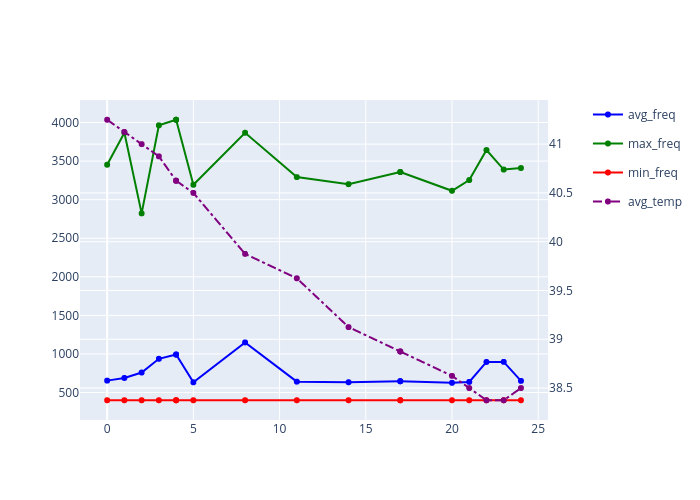

In [4]:
if __name__ == '__main__':

    "Example of how to use it"
    
    sm = StatsMonitor()
    fig = sm.update(5, 1)
    fig = sm.update(5, 3)
    fig = sm.update(5, 1)
    fig.show(renderer="png")